# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры. 


Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Описание данных

- Признаки
  - RowNumber — индекс строки в данных
  - CustomerId — уникальный идентификатор клиента
  - Surname — фамилия
  - CreditScore — кредитный рейтинг
  - Geography — страна проживания
  - Gender — пол
  - Age — возраст
  - Tenure — количество недвижимости у клиента
  - Balance — баланс на счёте
  - NumOfProducts — количество продуктов банка, используемых клиентом
  - HasCrCard — наличие кредитной карты
  - IsActiveMember — активность клиента
  - EstimatedSalary — предполагаемая зарплата
- Целевой признак
  - Exited — факт ухода клиента


<a id='main'></a>
   # ОГЛАВЛЕНИЕ
### <a href='#step_1'>Шаг 1. Изучение и предобработка данных</a> 

    
### <a href='#step_2'>Шаг 2. Исследование задачи</a>     

### <a href='#step_3'>Шаг 3. Борьба с дисбалансом</a>    



### <a href='#step_4'>Шаг 4. Тестирование модели</a>    



### <a href='#step_5'>Шаг 5. Вывод</a> 

  ---------------

# 1. Подготовка данных

### Подключение библиотек

In [1]:
# отключение предупреждений
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import matplotlib.ticker as ticker
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

small, medium, large = 14, 16, 22
params = {'figure.figsize': (16, 6),
'figure.titlesize': medium,
'legend.fontsize': small,
'axes.titlesize': small,
'axes.labelsize': small,
'xtick.labelsize': small,
'ytick.labelsize': small,
'legend.loc': 'best'}
plt.rcParams.update(params)

In [3]:
# повышение четкости графиков для больших мониторов
%config InlineBackend.figure_format = 'retina'

### Загрузка данныих и первичный осмотр

In [4]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Приведем к нижнему регистру имена колонок

In [6]:
df.columns = [x.lower() for x in df.columns.tolist()]
df.columns

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object')

### Дубликаты

In [7]:
df.duplicated().sum()

0

In [8]:
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалим столбцы не несущие полезной информации. 

In [9]:
df = df.drop(['rownumber', 'customerid', 'surname'], axis=1)

### Пропущенные значения

##### Подсчитаем количество пропущенных значений и их долю

In [10]:
print(df.tenure.isna().sum(), df.tenure.isna().sum()/df.shape[0]*100, sep='\n')

909
9.09


In [11]:
df.tenure.value_counts().sort_index()

0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: tenure, dtype: int64

#### Мы имеем 909 пропущенных значений в столбце Tenure, количество недвижимости у клиента, что составляет 9% от объема всех данных по столбцу.

#### Восстановим данные, заменим пропущенные значения на мединное значение в группе, а оставшиеся заменим нулем

In [12]:
df.loc[:, 'tenure'] = (df
                         .groupby(['geography', 'gender', 'age', 'numofproducts', 'hascrcard', 'isactivemember'])
                         .transform(lambda xs: xs.fillna(xs.median())))

print(df.tenure.isna().sum(), df.tenure.isna().sum()/df.shape[0]*100, sep='\n')

65
0.65


In [13]:
df['tenure'] = df['tenure'].fillna(0)
print(df.tenure.isna().sum(), df.tenure.isna().sum()/df.shape[0]*100, sep='\n')

0
0.0


### Кодировка *Geography* и *Gender* методом 'One-Hot Encoding'

In [14]:
df = pd.get_dummies(df, drop_first=True)

In [15]:
df.head()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [16]:
df.columns = [x.lower() for x in df.columns.tolist()]
df.columns

Index(['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited', 'geography_germany',
       'geography_spain', 'gender_male'],
      dtype='object')

### Типы данных

In [17]:
df.dtypes

creditscore            int64
age                    int64
tenure               float64
balance              float64
numofproducts          int64
hascrcard              int64
isactivemember         int64
estimatedsalary      float64
exited                 int64
geography_germany      uint8
geography_spain        uint8
gender_male            uint8
dtype: object

In [18]:
df.memory_usage(index=True).sum()

750128

#### Изменим типы данных с целью уменьшения занимаемой памяти

In [19]:
df['age'] = df['age'].astype('int8')
df['tenure'] = df['tenure'].astype('int8')
df['exited'] = df['exited'].astype('int8')
df['balance'] = df['balance'].astype('int32')
df['hascrcard'] = df['hascrcard'].astype('int8')
df['creditscore'] = df['creditscore'].astype('int16')
df['numofproducts'] = df['numofproducts'].astype('int8')
df['isactivemember'] = df['isactivemember'].astype('int8')
df['estimatedsalary'] = df['estimatedsalary'].astype('int32')

In [20]:
df.memory_usage(index=True).sum()

190128

### Распределения признаков и целевой переменной

In [21]:
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_germany,geography_spain,gender_male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.960600,76485.571500,1.530200,0.70550,0.515100,100089.748400,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.843353,62397.185107,0.581654,0.45584,0.499797,57510.491042,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51001.750000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.000000,1.000000,1.00000,1.000000,100193.500000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127643.750000,2.000000,1.00000,1.000000,149387.750000,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.000000,4.000000,1.00000,1.000000,199992.000000,1.000000,1.000000,1.000000,1.000000


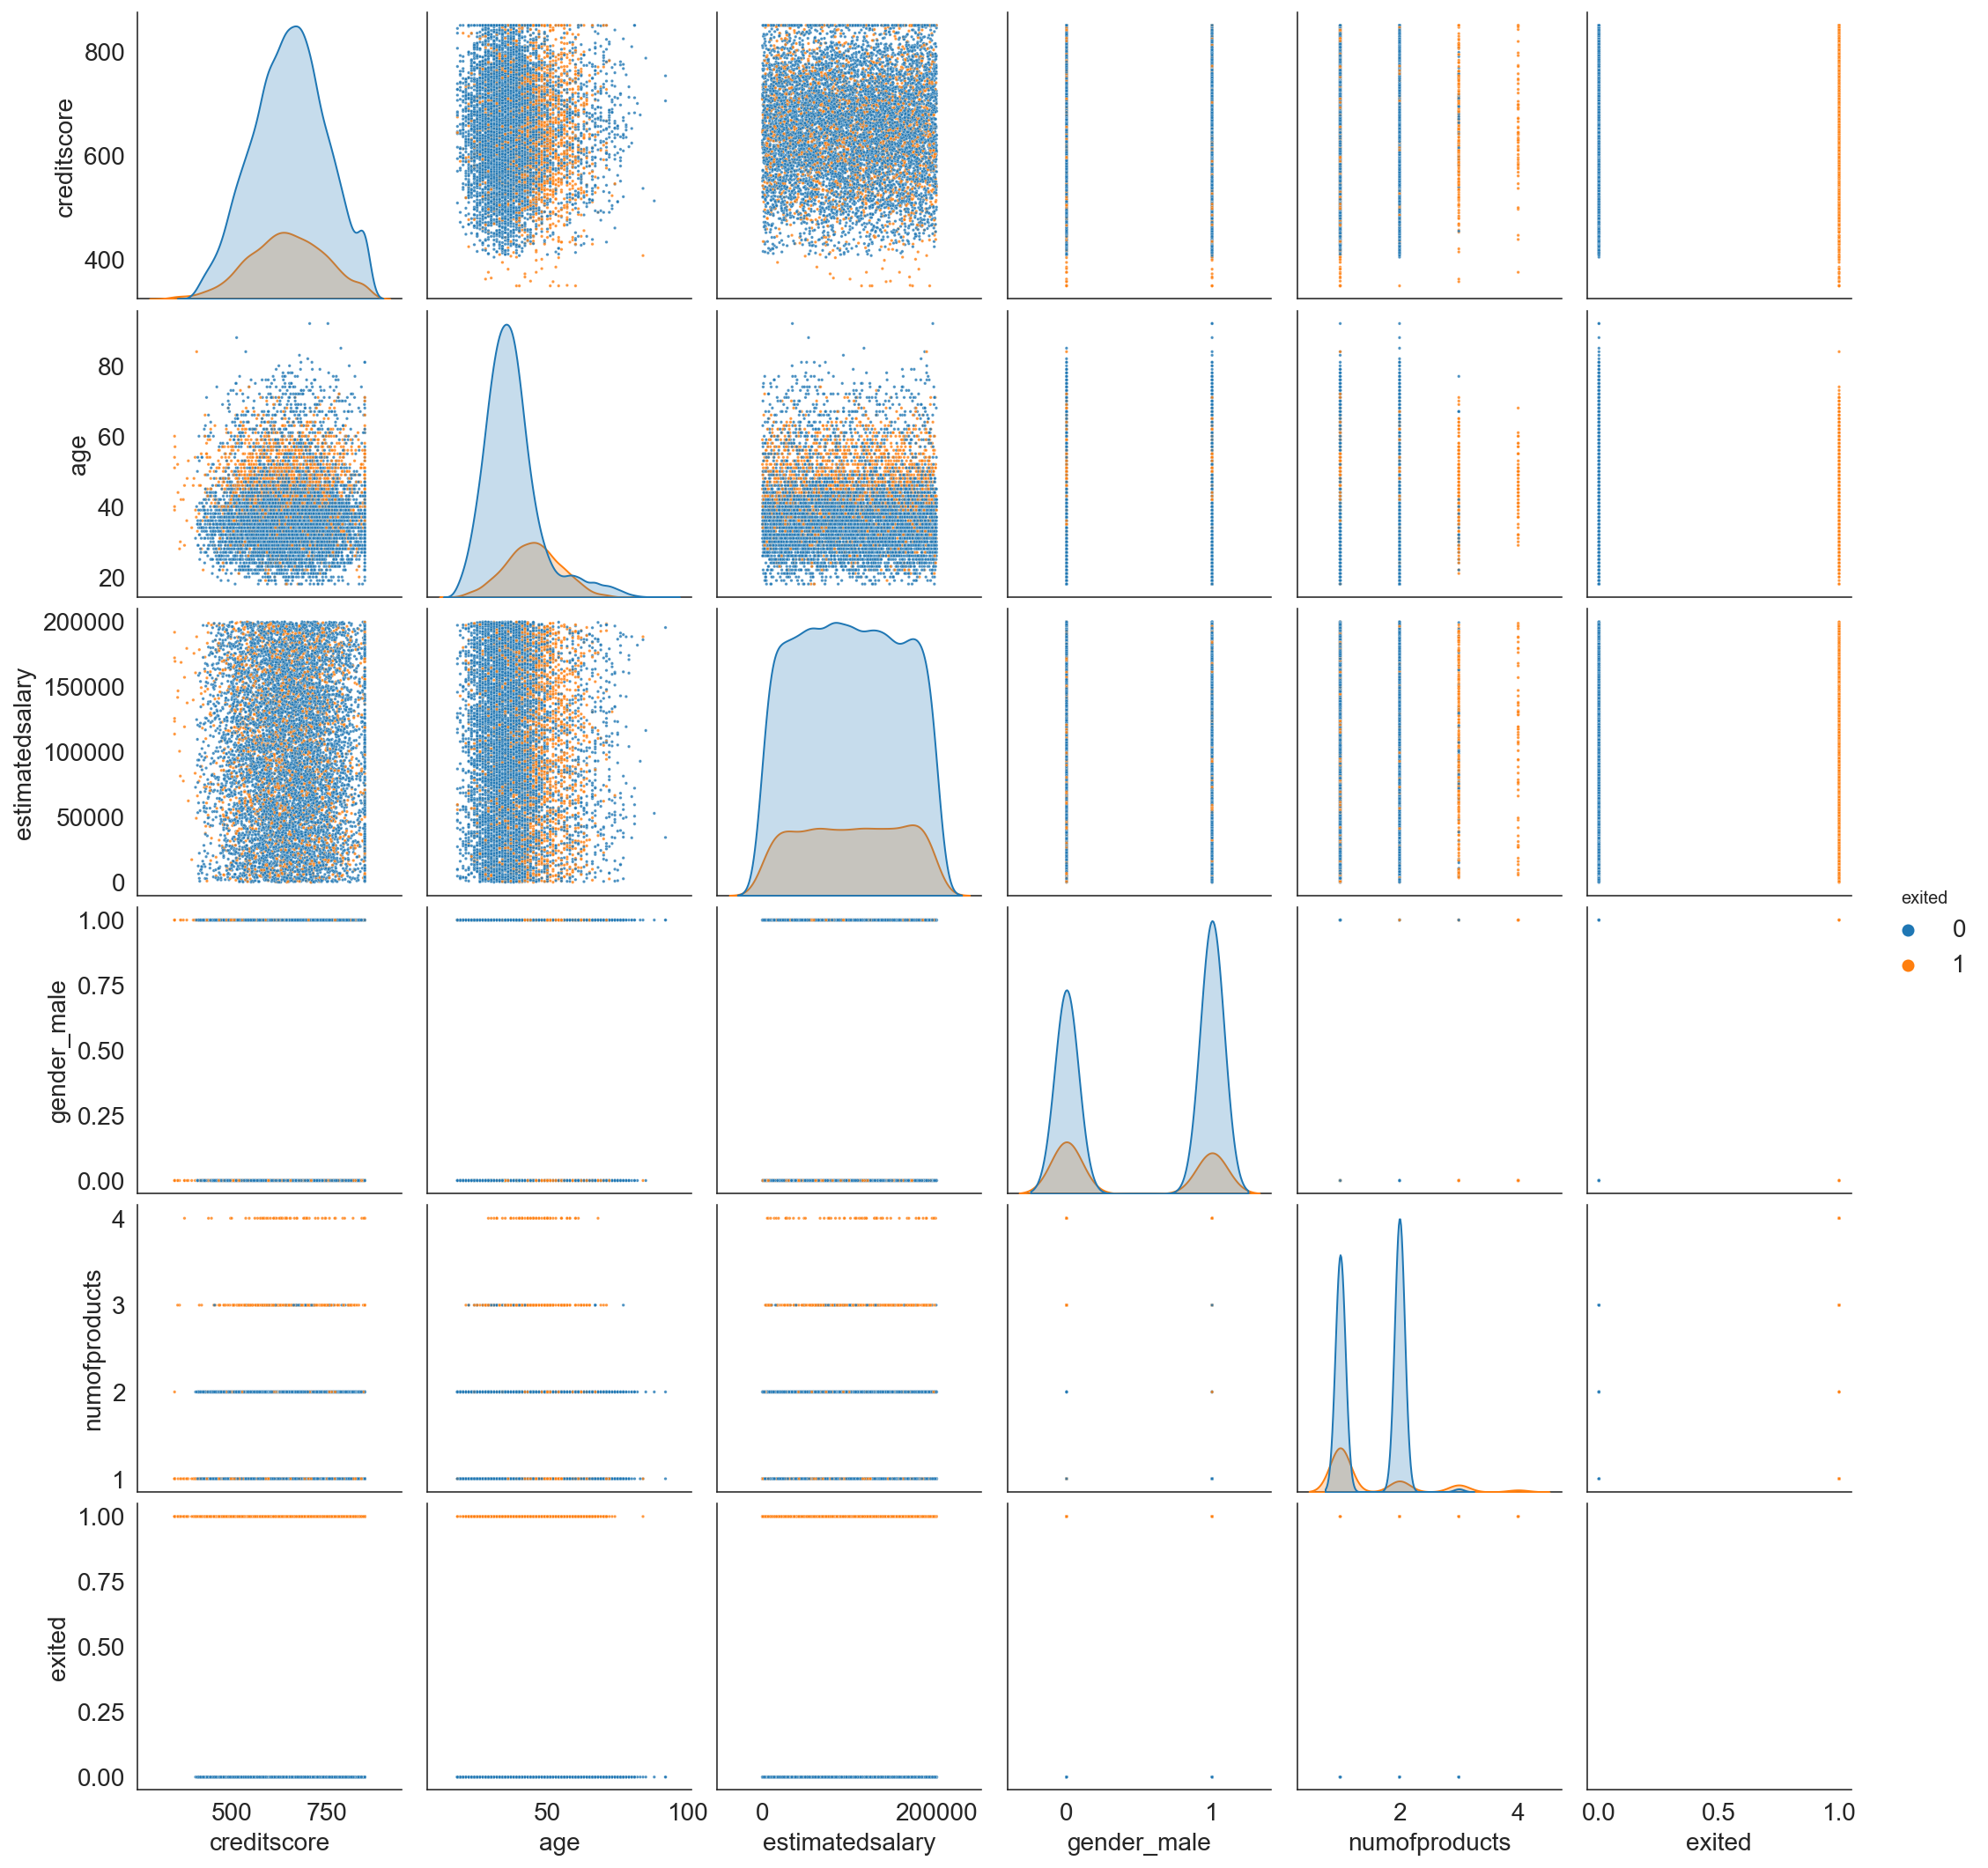

In [22]:
sns.pairplot(df, 
             hue='exited', 
             plot_kws={'s': 3, 'alpha': 0.8},
             x_vars=["creditscore", "age", "estimatedsalary", "gender_male", 'numofproducts', 'exited'],
             y_vars=["creditscore", "age", "estimatedsalary", "gender_male", 'numofproducts', 'exited'])

Мы наблюдаем некоторую зависимость между данными:

'creditscore' vs 'age'

'estimatedsalary' vs 'age'


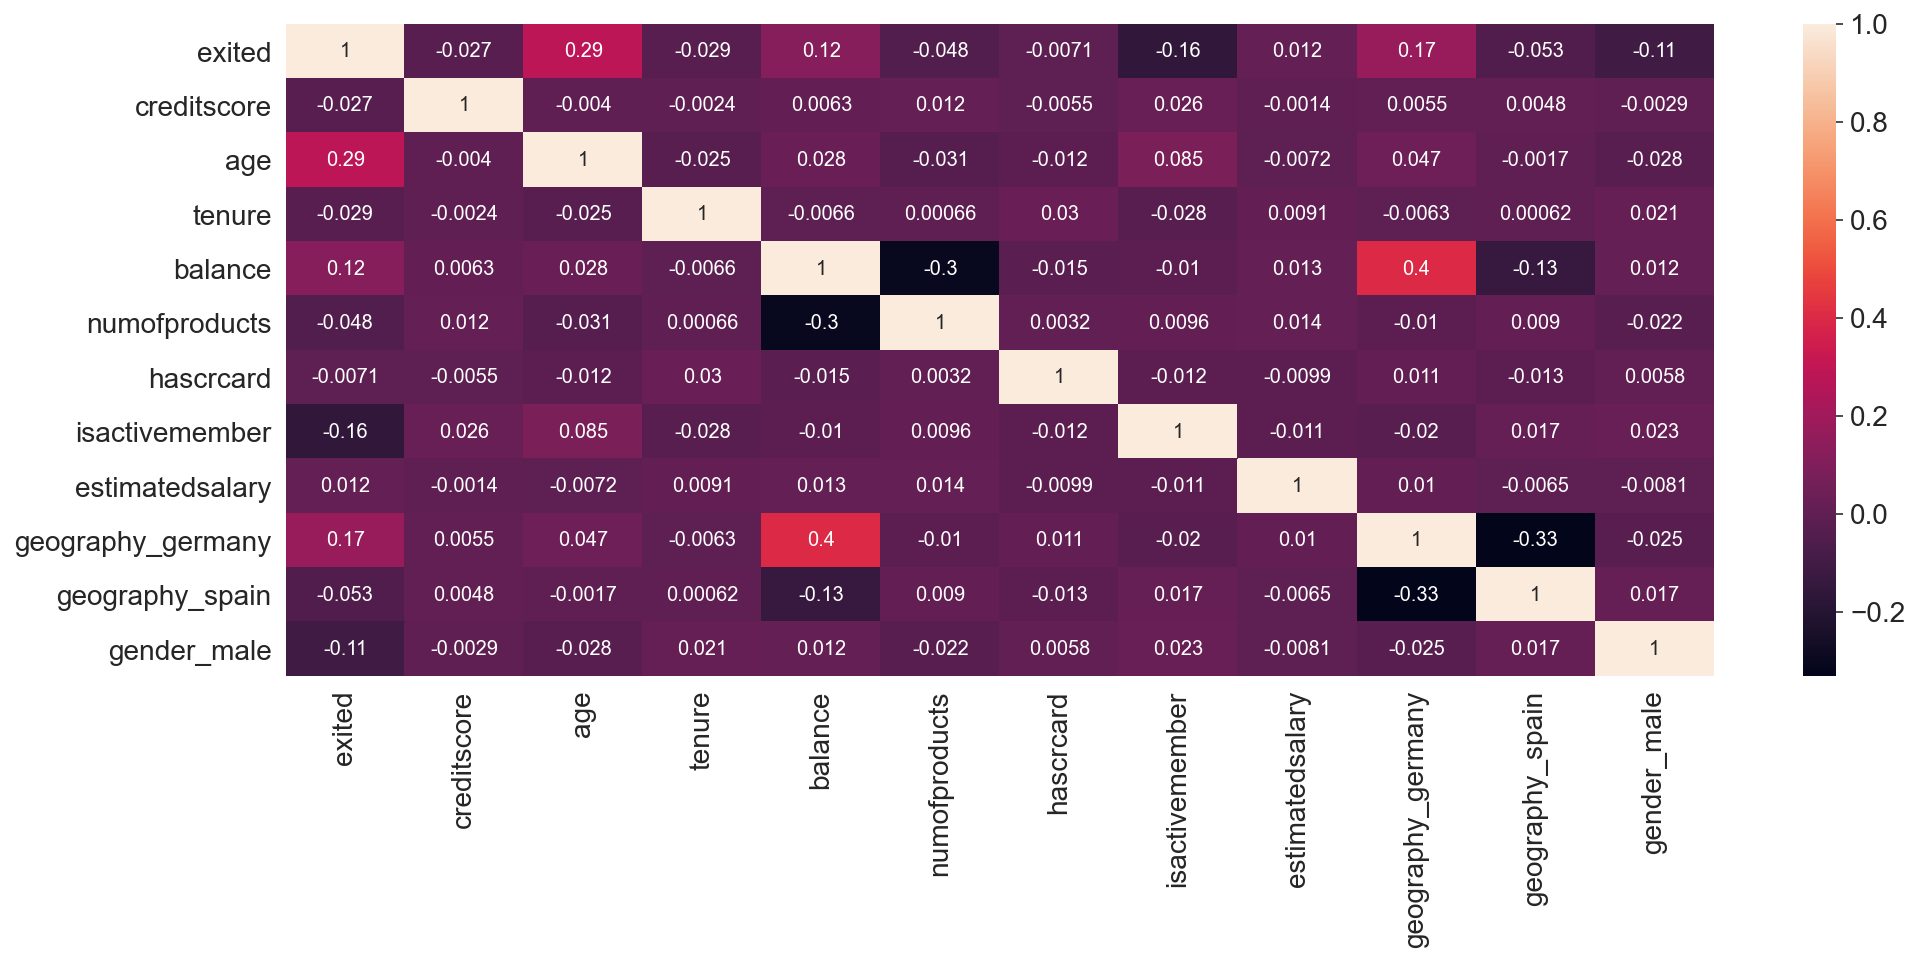

In [23]:
QQQ = sns.heatmap(df[['exited', "creditscore", "age", 'tenure', 'balance', 'numofproducts', 
                      'hascrcard', 'isactivemember', "estimatedsalary", 'geography_germany', 
                      'geography_spain', "gender_male",
                     ]].corr(),annot=True)

Мы наблюдаем на тепловой карте:

- у целевого признака 'exited' присутствует небольшая корреляция с возрастом

- корреляция между баллансом и географическим положением Германия.

- отрицательная корр связь между 'numofproducts' и 'balance', с ростом объема баланса уменьшается количество пользуемых продуктов


##### Проверим степень влияния различных факторов на качество прогноза после выбора модели

### Вывод:

Мы подключили необходимые библиотеки для дальшейшей работы, настроили рабоче пространство.

Загрузили и изучили данные, заполнили пропуски, уменьшили потребление памяти путем изменения типа данных, изучили взаимосвязи факторов в датасете.

## Разделение данных на обучающую, валидационную и тестовую выборки

In [24]:
RANDOM_STATE = 12345

In [25]:
X, y = df.drop(columns=['exited']), df['exited']

In [26]:
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y)

In [27]:
X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test, y_valid_test, test_size=0.5, random_state=RANDOM_STATE, stratify=y_valid_test)

In [28]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


### Масштабирование признаков

In [29]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary', 'numofproducts']

scaler = StandardScaler()

scaler.fit(X_train[numeric])

StandardScaler()

In [30]:
# преобразуем обучающие данные
X_train[numeric] = scaler.transform(X_train[numeric])

# преобразуем валидационные данные (на настройках полученных на тренировочных данных)
X_valid[numeric] = scaler.transform(X_valid[numeric])

# преобразуем валидационные данные (на настройках полученных на тренировочных данных)
X_test[numeric] = scaler.transform(X_test[numeric])

In [31]:
# посмотрим степень разбалансировки данных
y_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: exited, dtype: float64

### Вывод:

Мы разделили данные на тренировочные, валидационные и тестовые выборки, также мы масштабировали признаки.

Также мы выяснили, что данные были сильно разбалансированны.

### <a href='#main'>В начало</a> 

# 2. Исследование задачи
<a id='step_2'></a>

### Обучение модели на несбалансированных данных

#### Логистическая регрессия

In [32]:
%%time
clf = LogisticRegression(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)


print(
'''f1_score = {}
score_train = {}
score_valid = {}
'''.format(f1_score(y_valid, clf.predict(X_valid)).round(3),
clf.score(X_train, y_train).round(3),
clf.score(X_valid, y_valid).round(3))
     )

f1_score = 0.308
score_train = 0.812
score_valid = 0.811

CPU times: user 96.4 ms, sys: 32 ms, total: 128 ms
Wall time: 35.4 ms


#### Случайный лес

In [33]:
%%time
clf = RandomForestClassifier(random_state=RANDOM_STATE)
clf.fit(X_train, y_train)


print(
'''f1_score = {}
score_train = {}
score_valid = {}
'''.format(f1_score(y_valid, clf.predict(X_valid)).round(3),
clf.score(X_train, y_train).round(3),
clf.score(X_valid, y_valid).round(3))
     )

f1_score = 0.608
score_train = 1.0
score_valid = 0.87

CPU times: user 1.55 s, sys: 203 ms, total: 1.75 s
Wall time: 614 ms


#### Случайный лес с подбором глубины и кол-ва деревьев

In [34]:
%%time
max_F1 = 0
best_depth = 0
best_trees = 0

for est in range(1, 50):
    for depth in range(1, 10):
        clf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
        clf.fit(X_train, y_train)
        score = clf.score(X_valid, y_valid)
        
        y_pred = clf.predict(X_valid)
        F1 = f1_score(y_valid, y_pred)
        
        if F1 > max_F1:
            max_F1 = F1
            best_clf = clf
            score_valid = score
            best_trees = est 
            best_depth = depth

CPU times: user 31.8 s, sys: 110 ms, total: 31.9 s
Wall time: 31.9 s


In [35]:
print(
'''
Глубина = {}
Кол-во деревьев = {}
f1_score = {}
score_train = {}
score_valid = {}
'''.format(best_clf.max_depth,
           best_clf.n_estimators,
           f1_score(y_valid, clf.predict(X_valid)).round(3),
           clf.score(X_train, y_train).round(3),
           clf.score(X_valid, y_valid).round(3))
     )


Глубина = 4
Кол-во деревьев = 1
f1_score = 0.584
score_train = 0.891
score_valid = 0.866



### Вывод:

Мы обучили 3 модели на несбалансированных данных.

Проверили на валидационной и тестовой выборках.

Наилучший результат по F1 показала модель Случайный лес с подборанным кол-вом деревьев и глубины.



### <a href='#main'>В начало</a> 

# 3. Борьба с дисбалансом
<a id='step_3'></a>

##### Произведем балансировку тренировочных данных, для этого оценим эффективность up-sampling  и использования параметра class_weight = 'balanced'

In [36]:
# разделим выборки в зависимости от значения целевого признака
X_train_0 = X_train[y_train == 0] 
X_train_1 = X_train[y_train == 1]
y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1]

Произведем анализ чувствительности модели к изменению соотношений в выборке признаков соответствующих отрицательным ТN и положительным TР значениям целевого показателя.

Для анализа используем модель RandomForestClassifier с уже отобранными параметрами.

In [37]:
%%time

# произведем подбор параметров для up-sampling
max_F1 = 0
best_upsampling_multiplier = 0
best_trees, best_depth = 0, 0

upsampling_multiplier_range = [1,2,3,4,5]
downsampling_fraction_range = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

for upsampling_multiplier in upsampling_multiplier_range:

    X_train_sampled = pd.concat(
        [X_train_0] + [X_train_1] * upsampling_multiplier)
    y_train_sampled = pd.concat(
        [y_train_0] + [y_train_1] * upsampling_multiplier)

    # перемешаем тренировочную выборку после семплинга
    X_train_sampled, y_train_sampled = shuffle(X_train_sampled, y_train_sampled, random_state=RANDOM_STATE)

    for est in range(1, 50):
        for depth in range(1, 10):

            clf = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=depth, n_estimators = est)
            clf.fit(X_train_sampled, y_train_sampled)

            y_pred = clf.predict(X_valid)

            # оценка метрик
            F1 = f1_score(y_valid, y_pred)

            # выбор наилучшего показателя для параметров семплинга
            if F1 > max_F1:
                max_F1 = F1
                best_upsampling_multiplier = upsampling_multiplier
                score_valid = score
                best_trees = est 
                best_depth = depth
           
    
print("\nЛучшее значение F1 (на валидац.выборке):", max_F1.round(6),
      "\nЛучшее значение множителя для up-sampling", best_upsampling_multiplier,
      '\nЛучшее значение score_valid', score_valid,
      '\nЛучшее значение best_trees ', best_trees,
      '\nЛучшее значение best_depth', best_depth
     )


Лучшее значение F1 (на валидац.выборке): 0.655949 
Лучшее значение множителя для up-sampling 4 
Лучшее значение score_valid 0.866 
Лучшее значение best_trees  36 
Лучшее значение best_depth 9
CPU times: user 3min 14s, sys: 1e+03 ms, total: 3min 15s
Wall time: 3min 16s


- #### Мы наблюдаем прирост метрики F1

Оценим эффективность использования параметра class_weight = 'balanced'

используем модель RandomForestClassifier с полученными ранее настройками и данные без какого-либо семплинга

In [38]:
clf = RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth, random_state=RANDOM_STATE, class_weight = 'balanced')
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid)
y_pred = clf.predict(X_valid)
F1 = f1_score(y_valid, y_pred)
print("значение F1 (на валидац.выборке):", F1.round(4))

значение F1 (на валидац.выборке): 0.6393




- ##### Прирост есть, но у семплинга сильнее

##### Произведем up-sampling в соответствии с полученными параметрами.

In [39]:
# до
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(6000, 11) (2000, 11) (2000, 11)
(6000,) (2000,) (2000,)


In [40]:
X_train = pd.concat(
    [X_train_0] + [X_train_1] * best_upsampling_multiplier)
y_train = pd.concat(
    [y_train_0] + [y_train_1] * best_upsampling_multiplier)

X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_STATE)

In [41]:
# после
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(9666, 11) (2000, 11) (2000, 11)
(9666,) (2000,) (2000,)


In [42]:
%%time
clf = RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
score = clf.score(X_valid, y_valid)
y_pred = clf.predict(X_valid)
F1 = f1_score(y_valid, y_pred)
print("значение F1 (на валидац.выборке):", F1.round(4))

значение F1 (на валидац.выборке): 0.6559
CPU times: user 215 ms, sys: 1.57 ms, total: 217 ms
Wall time: 219 ms


#### Вывод:

Мы оптимизировали параметры моделей исходя из качества на валидационной выборке

#### <a href='#main'>В начало</a> 

##### Выбор оптимальной модели и ее параметров на сбалансированной тренировочной выборке

#### Логистическая регрессия

In [43]:
%%time
LGR = LogisticRegression(random_state=RANDOM_STATE)
LGR.fit(X_train, y_train)

print(
'''f1_score = {}
score_train = {}
score_valid = {}
'''.format(f1_score(y_valid, clf.predict(X_valid)).round(3),
clf.score(X_train, y_train).round(3),
clf.score(X_valid, y_valid).round(3))
     )

f1_score = 0.656
score_train = 0.868
score_valid = 0.84

CPU times: user 364 ms, sys: 76.2 ms, total: 440 ms
Wall time: 79.5 ms


In [44]:
probabilities_valid = LGR.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_LGR, tpr_LGR, thresholds = roc_curve(y_valid, probabilities_one_valid)

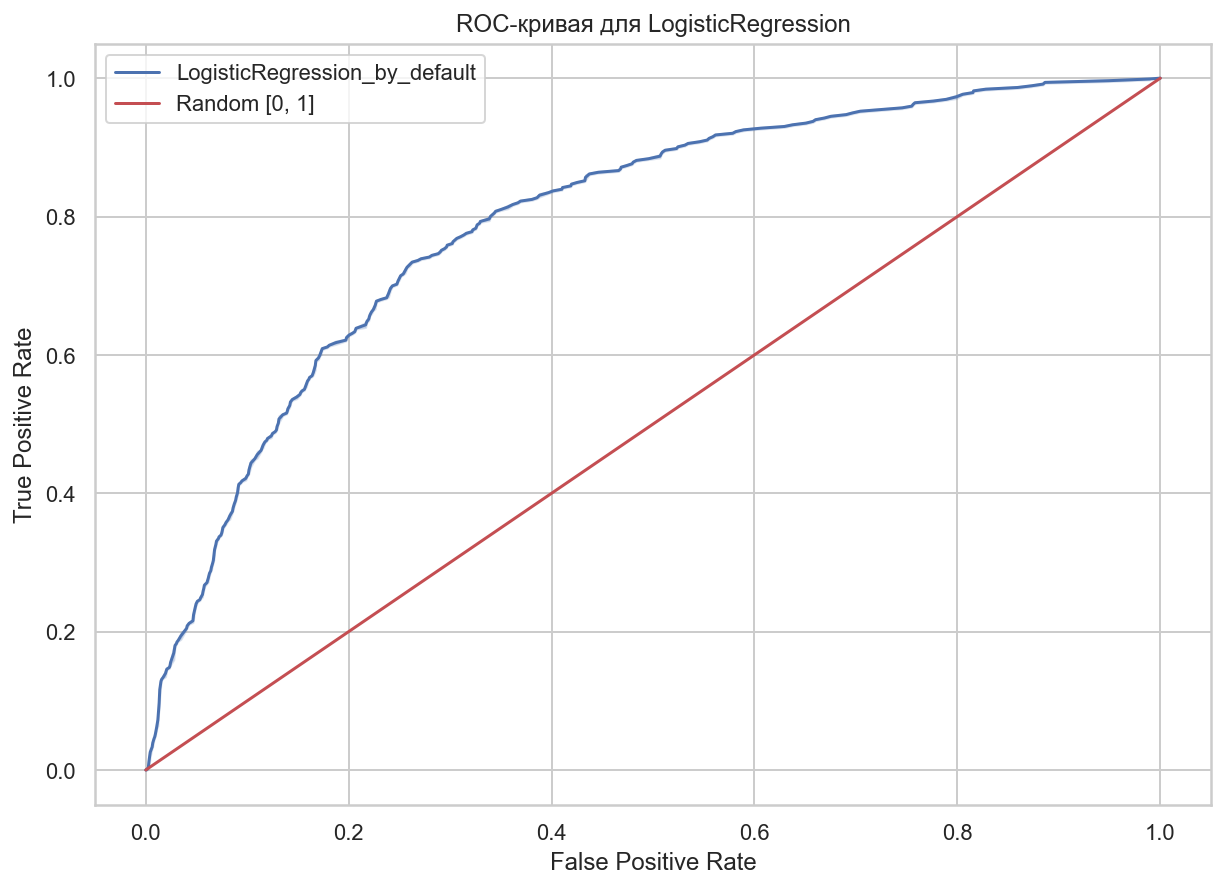

In [45]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
sns.lineplot(x=fpr_LGR, y=tpr_LGR) # LogisticRegression
sns.lineplot(x=[0, 1], y=[0, 1], color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['LogisticRegression_by_default', 'Random [0, 1]'])
plt.title('ROC-кривая для LogisticRegression')
plt.show()

#### Дерево решений

In [46]:
%%time
DtC = DecisionTreeClassifier(random_state=RANDOM_STATE)
DtC.fit(X_train, y_train)

print(
'''f1_score = {}
score_train = {}
score_valid = {}
'''.format(f1_score(y_valid, clf.predict(X_valid)).round(3),
clf.score(X_train, y_train).round(3),
clf.score(X_valid, y_valid).round(3))
     )

f1_score = 0.656
score_train = 0.868
score_valid = 0.84

CPU times: user 75.3 ms, sys: 853 µs, total: 76.2 ms
Wall time: 75.5 ms


In [47]:
probabilities_valid = DtC.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_DtC, tpr_DtC, thresholds = roc_curve(y_valid, probabilities_one_valid)

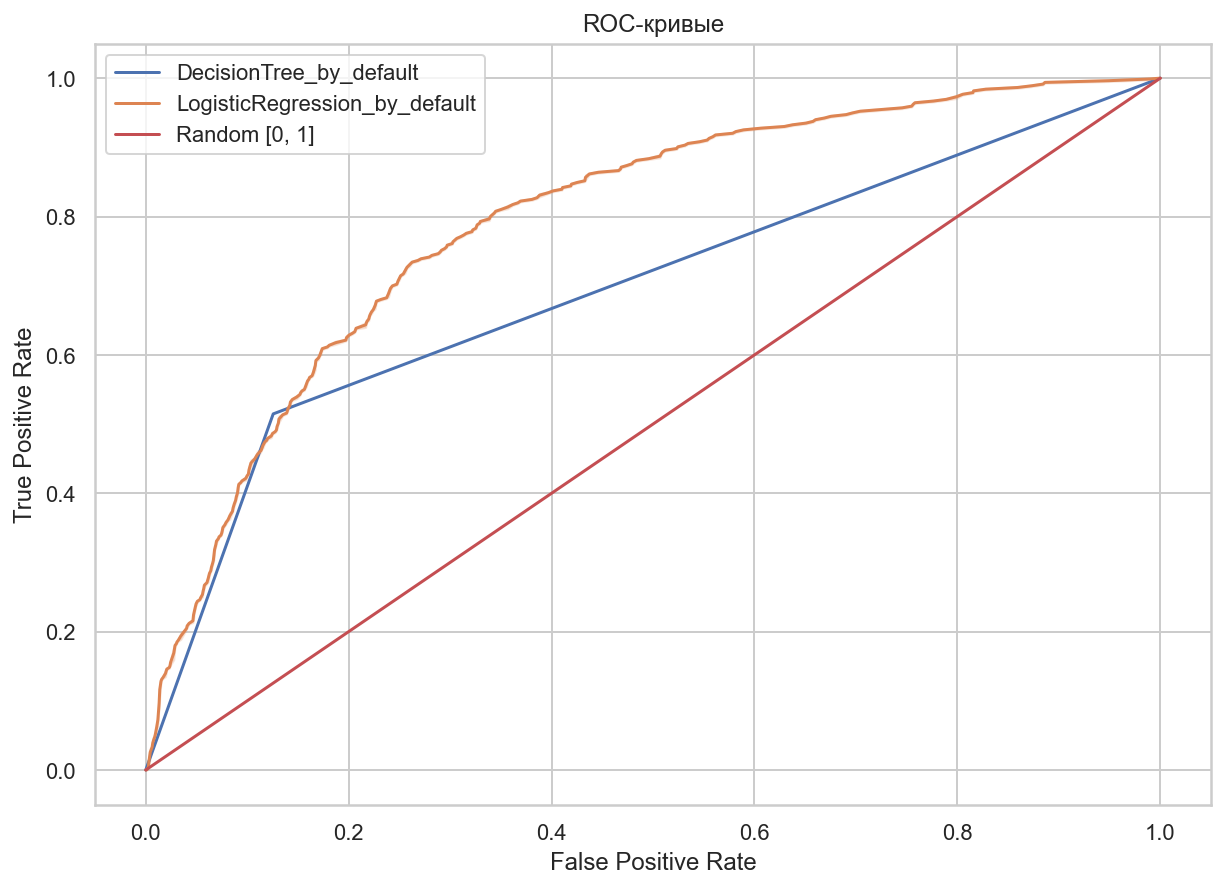

In [48]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
sns.lineplot(x=fpr_DtC, y=tpr_DtC) # DecisionTreeClassifier by default
sns.lineplot(x=fpr_LGR, y=tpr_LGR) # LogisticRegression
sns.lineplot(x=[0, 1], y=[0, 1], color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['DecisionTree_by_default', 'LogisticRegression_by_default', 'Random [0, 1]'])
plt.title('ROC-кривые')
plt.show()

#### Дерево решений с подбором оптимальной высоты

In [49]:
%%time
max_depth = 35
best_score = 0
max_F1 = 0

train_scores = []
valid_scores = []
F1_scores = []


for depth in range(1, max_depth+1):
    DtC_2 = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    DtC_2.fit(X_train, y_train)
    
    train_scores.append(DtC_2.score(X_train, y_train))
    
    valid_score = DtC_2.score(X_valid, y_valid)
    valid_scores.append(valid_score)
    
    y_pred = DtC_2.predict(X_valid)
    F1 = f1_score(y_valid, y_pred)
    F1_scores.append(F1)
    
    if F1 > max_F1:
        max_F1 = F1
        best_DtC_2 = DtC_2
        best_valid = valid_score

CPU times: user 944 ms, sys: 3.05 ms, total: 947 ms
Wall time: 949 ms


In [50]:
print(
'''
Глубина = {}
f1_score = {}
score_train = {}
score_valid = {}
'''.format(best_DtC_2.max_depth,
           f1_score(y_valid, best_DtC_2.predict(X_valid)).round(3),
           best_DtC_2.score(X_train, y_train).round(3),
           best_valid.round(3))
     )


Глубина = 6
f1_score = 0.576
score_train = 0.792
score_valid = 0.771



In [51]:
probabilities_valid = best_DtC_2.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_best_DtC_2, tpr_best_DtC_2, thresholds = roc_curve(y_valid, probabilities_one_valid)

#### Случайный лес: подбор глубины и кол-ва деревьев

In [52]:
%%time

max_F1 = 0

for est in range(1, 50): 
    for depth in range(4, 20): 
        RF_2 = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=RANDOM_STATE)
        RF_2.fit(X_train, y_train)
        score = RF_2.score(X_valid, y_valid)
        
        y_pred = RF_2.predict(X_valid)
        F1 = f1_score(y_valid, y_pred)
        
        if F1 > max_F1:
            max_F1 = F1
            best_RF_2 = RF_2
            score_valid = score

CPU times: user 2min, sys: 314 ms, total: 2min 1s
Wall time: 2min 1s


In [53]:
print(
'''
Глубина = {}
Кол-во деревьев = {}
f1_score = {}
score_train = {}
score_valid = {}
'''.format(best_RF_2.max_depth,
           best_RF_2.n_estimators,
           f1_score(y_valid, best_RF_2.predict(X_valid)).round(3),
           best_RF_2.score(X_train, y_train).round(3),
           best_RF_2.score(X_valid, y_valid).round(3))
     )


Глубина = 9
Кол-во деревьев = 36
f1_score = 0.656
score_train = 0.868
score_valid = 0.84



In [54]:
probabilities_valid = best_RF_2.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_best_RF_2, tpr_best_RF_2, thresholds = roc_curve(y_valid, probabilities_one_valid)

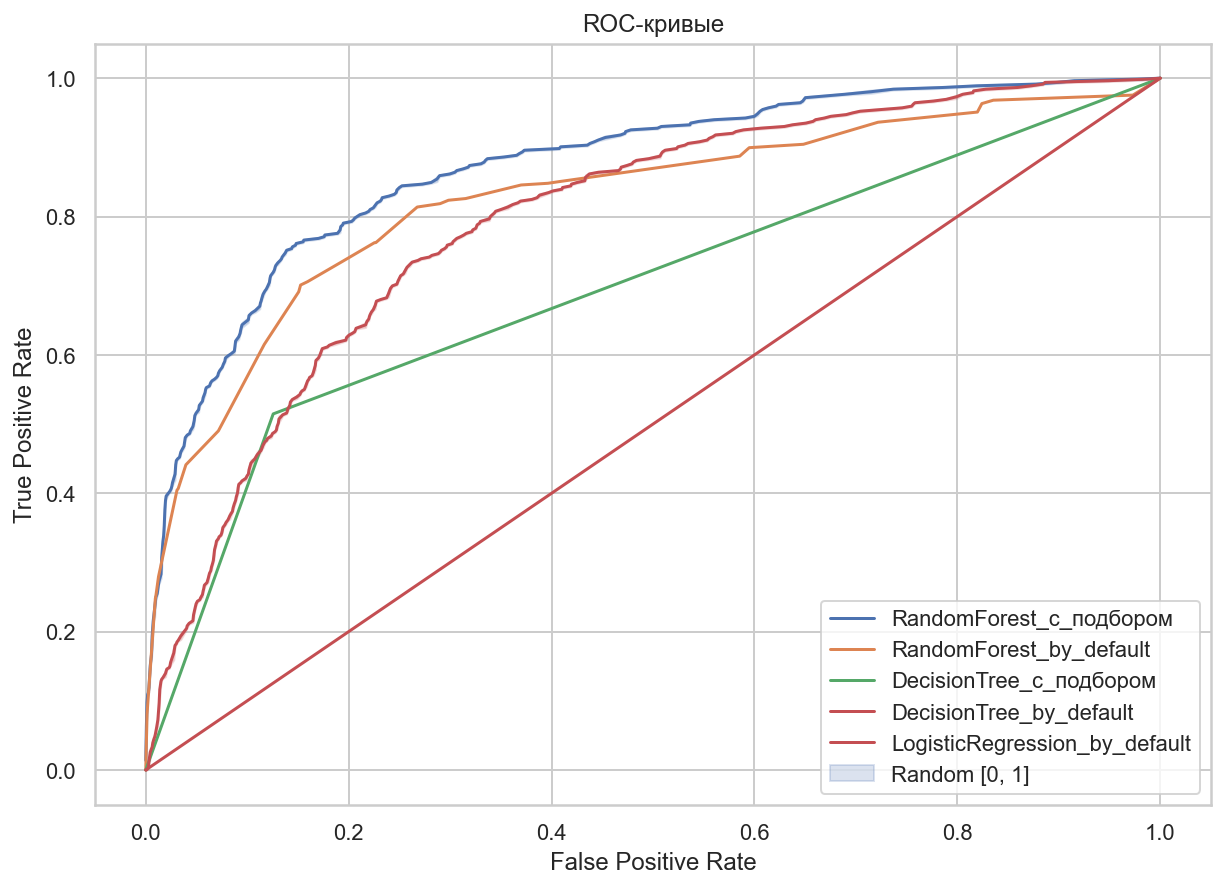

In [55]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
sns.lineplot(x=fpr_best_RF_2, y=tpr_best_RF_2) #  RandomForestClassifier_с подбором
sns.lineplot(x=fpr_best_DtC_2, y=tpr_best_DtC_2) # DecisionTreeClassifier с подбором
sns.lineplot(x=fpr_DtC, y=tpr_DtC) # DecisionTreeClassifier by default
sns.lineplot(x=fpr_LGR, y=tpr_LGR) # LogisticRegression
sns.lineplot(x=[0, 1], y=[0, 1], color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['RandomForest_c_подбором', 'RandomForest_by_default', 'DecisionTree_с_подбором', 'DecisionTree_by_default', 'LogisticRegression_by_default', 'Random [0, 1]'])
plt.title('ROC-кривые')
plt.show()

#### Вывод:

Лучший результат по метрике F1 показала модель RandomForestClassifier.

в соответствии с заданием, нам необходимо проверить результаты на тестовой модели.

в следующем разделе мы объединим тренировочную и валидационную выборки, обучим модель с полученными параметрами и проверим еще раз на тестовой выборке.

для проверки будет использована модель RandomForestClassifier с параметрами - глубина - 7, кол-во деревьев - 12.

# 4. Тестирование модели
<a id='step_4'></a>

Объединим тренировочную и валидационную выборки

In [56]:
# до
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(9666, 11) (2000, 11) (2000, 11)
(9666,) (2000,) (2000,)


In [57]:
# объединяем тренировочную и валидационные выборки

X_train = pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_train = pd.concat([y_train, y_valid], axis=0, ignore_index=True)

In [58]:
# после 
print(X_train.shape, y_train.shape)

(11666, 11) (11666,)


Обучим модель с подобранными гиперпараметрами на новой выборке

In [59]:
%%time

max_F1 = 0


RF_2 = RandomForestClassifier(n_estimators=best_RF_2.n_estimators, max_depth=best_RF_2.max_depth, random_state=RANDOM_STATE)
RF_2.fit(X_train, y_train)
score = RF_2.score(X_valid, y_valid)

y_pred = RF_2.predict(X_test)

print('метрики по тестовой выборке:')
print('Accuracy: ', accuracy_score(y_test, y_pred).round(4))
print('F1 мера: ', f1_score(y_test, y_pred))
print('Точность: ', precision_score(y_test, y_pred).round(4))
print('Полнота: ', recall_score(y_test, y_pred).round(4))
print('Площадь под ROC-кривой: ', roc_auc_score(y_test, y_pred).round(4))

метрики по тестовой выборке:
Accuracy:  0.8355
F1 мера:  0.6133960047003526
Точность:  0.5878
Полнота:  0.6413
Площадь под ROC-кривой:  0.7632
CPU times: user 252 ms, sys: 2.15 ms, total: 254 ms
Wall time: 259 ms


In [60]:
probabilities_valid = RF_2.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]
fpr_best_RF_2, tpr_best_RF_2, thresholds = roc_curve(y_test, probabilities_one_valid)

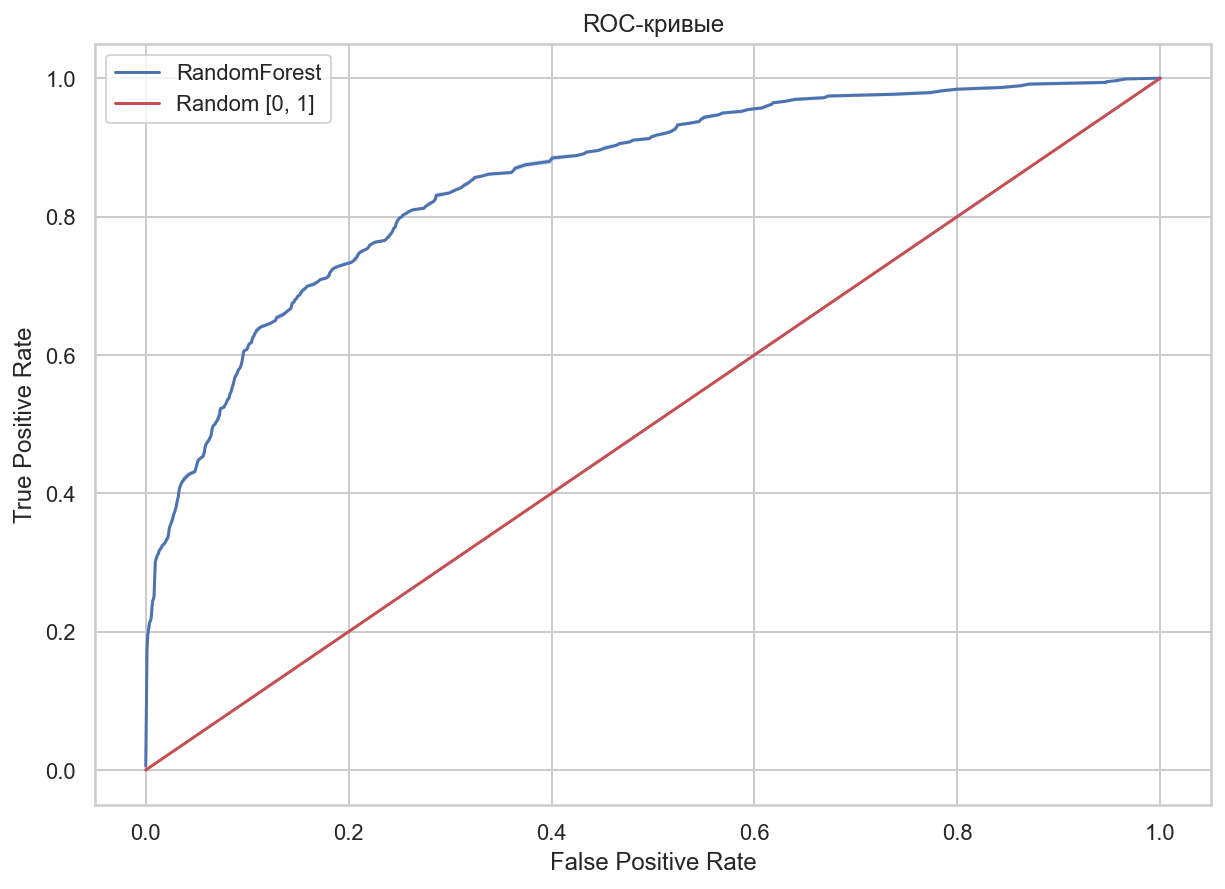

In [61]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.set_style("whitegrid")
sns.lineplot(x=fpr_best_RF_2, y=tpr_best_RF_2)

sns.lineplot(x=[0, 1], y=[0, 1], color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['RandomForest', 'Random [0, 1]'])
plt.title('ROC-кривые')
plt.show()

### <a href='#main'>В начало</a> 

## Вывод:
<a id='step_5'></a>

Мы обучили несколько моделей для прогноза целевого признака, и 
используя указанную в задании метрику (F1) выявили наиболее подходяющую модель RandomForestClassifier
максимально достигнутое значение F1 составляет 0.613396, что удовлетворяет поставленному нам заданию.

-----------------